In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import spacy
import re

from nltk.util import ngrams 

nlp = spacy.load('it_core_news_sm')

%matplotlib inline

## Example spacy.nlp()

In [92]:
s = 'Io sto bene. Siamo volontieri #male, @meloni, @russia https://url.de'
doc = nlp(s)

print(f"Token\t\tLemma\t\tUrl\tStopword")
print("="*40)
for token in doc:
    print(f"{token}\t\t{token.lemma_}\t\t{token.like_url}\t{token.is_stop}")

Token		Lemma		Url	Stopword
Io		io		False	True
sto		stare		False	True
bene		bene		False	True
.		.		False	False
Siamo		essere		False	True
volontieri		volontiero		False	False
#		#		False	False
male		male		False	True
,		,		False	False
@meloni		@melone		False	False
,		,		False	False
@russia		@russia		False	False
https://url.de		Https://url.de		True	False


## Tokenize and clean Tweets

In [184]:
def clean_text(text, search_words):
    doc = nlp(text)

    bog = []

    for token in doc:

        # filter stopwords
        if not token.is_stop:
            # filter punctiation
            if not token.is_punct:
                if not token.like_url:
                    if not token.like_email:
                        if not token.is_space:
                            if token.lemma_ not in ['\n', ' ']:
                                # filter words used to search for tweets            
                                if str(token) not in search_words:
                                    bog.append(re.sub('@', '', token.lemma_))
                                
    
    return bog

        

In [185]:
df = pd.read_csv("replies_1598431890960162847.csv")
df.head(2)

,Unnamed: 0,edit_history_tweet_ids,id,text
0,0,['1598624920140931072'],1598624920140931072,@GiorgiaMeloni @Palazzo_Chigi Thank you for yo...
1,1,['1598624696538484737'],1598624696538484737,@GiorgiaMeloni @CheikhGhazouani @Palazzo_Chigi...


In [186]:
# word that were part of the search (or highly related to it) should be filtered out
search_words = ['@GiorgiaMeloni', '@Palazzo_Chigi', '@CheikhGhazouani']

# tokenize and clean tweets
df['bog'] = df.text.apply(lambda x: clean_text(x, search_words))

# create bigrams that can be used as edges for a linguistic network
df['bigrams'] = df.bog.apply(lambda x: list(ngrams(x, 2)))

         word  count
0          il     13
1    italiano      8
2           o      6
3       دائما      6
4    vergogna      5
5  Mauritania      5
6     diritto      5
7     pensare      5
8      volere      5
9        euro      5


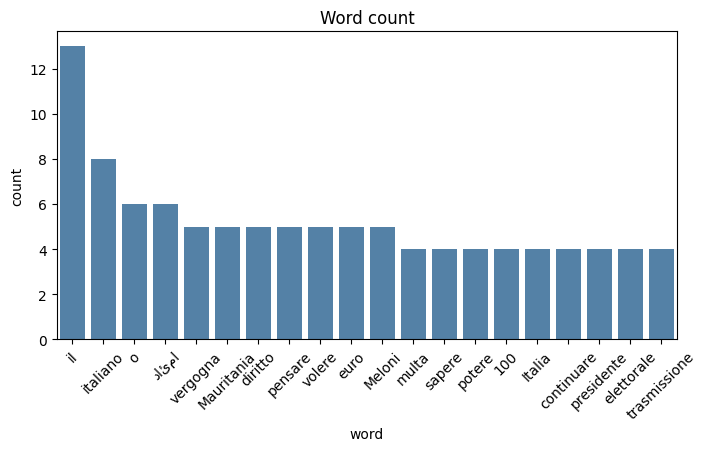

In [187]:
word_count = df.bog.explode().value_counts().reset_index().rename(columns={'index':'word', 'bog':'count'}).head(20)

# # top 10 degrees
print(word_count.head(10))

# plot distribution of degrees
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=word_count['word'], y=word_count['count'], ax=ax, color='steelblue')
ax.set_title('Word count')
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

## Linguistic network

In [216]:
# create edgelist from bigrams
edgelist = []
for edges in df.bigrams:
    edgelist = edgelist + edges

print(f'Number of edges: \t\t {len(edgelist)}')

# remove duplicates
edgelist = list(set(edgelist))

print(f'Number of unique edges: \t {len(edgelist)}')

Number of edges: 		 794
Number of unique edges: 	 722


In [217]:
# create graph from edgelist
G = nx.Graph()
G.add_edges_from(edgelist)

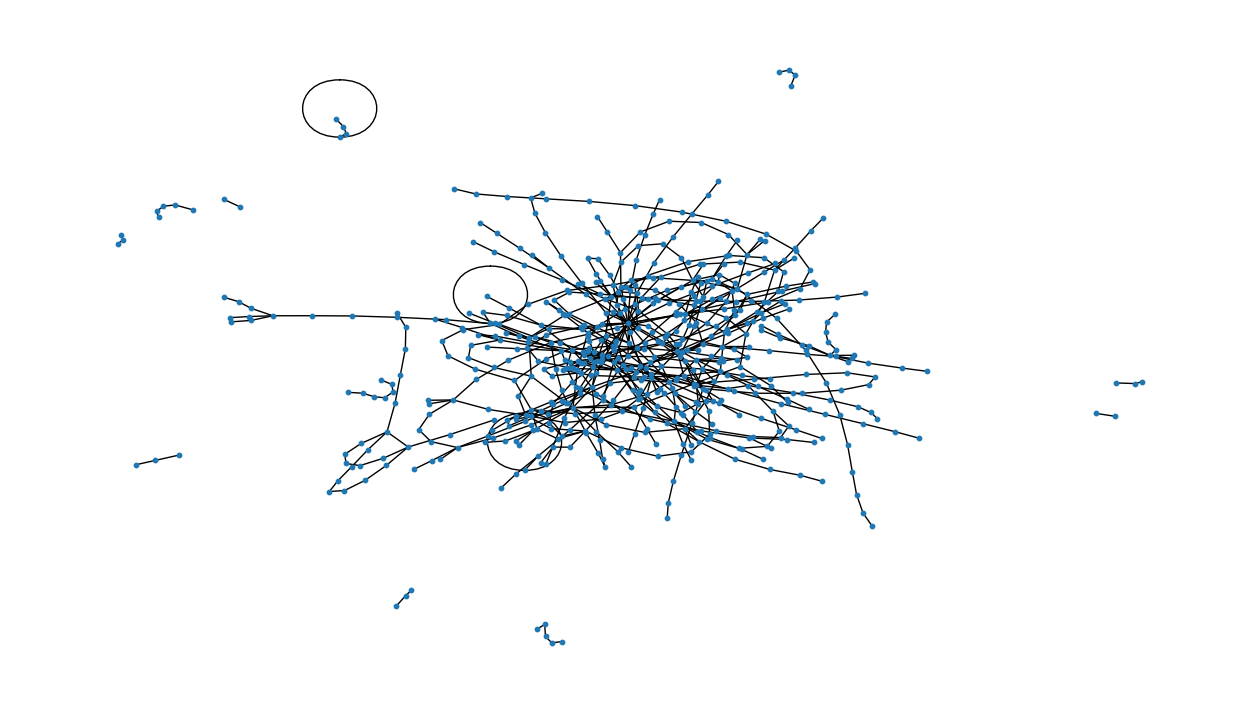

In [228]:
my_pos = nx.spring_layout(G, seed = 100)
fig, ax = plt.subplots(figsize=(16, 9))

nx.draw(G, node_size=10, pos=my_pos, ax=ax)

### Degree centrality

In [246]:
dc_raw = nx.degree_centrality(G)
dc = pd.DataFrame([(key, value) for key, value in dc_raw.items()], columns=['node', 'dc'])

In [251]:
dc.sort_values('dc', ascending=False).head(10)

,node,dc
89,il,0.040453
2,italiano,0.024272
23,o,0.019417
33,volere,0.016181
65,Meloni,0.014563
5,Mauritania,0.014563
146,euro,0.012945
63,Italia,0.012945
150,andare,0.012945
101,diritto,0.012945
